In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openTSNE import TSNE
from fdict import sfdict
from tqdm import tqdm
import numpy as np
import tensorflow as tf

2024-03-01 13:15:51.989168: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 13:15:52.013391: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 13:15:52.114687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 13:15:52.114740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 13:15:52.127778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
ngram_abstracts = np.load("files/ngram_abstracts_repl.npy", mmap_mode="r")
concept_arr = np.unique(np.load("files/overlapping_save_concepts.npy"))
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
month_arr = np.load("files/month_arr.npy", mmap_mode="r")

In [3]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr
df_ab["month_arr"] = month_arr

In [4]:
df_ab.head()

,ab,year,month_arr
0,it be outline the possibility to extend the qu...,2007,3
1,in a quantum mechanical model diosi feldmann a...,2007,4
2,a novel way of picture the processing of quant...,2008,5
3,we consider a single ion confine in a trap und...,2007,4
4,we show how a single trap_ion may be use to te...,2007,7


First pass: Find all occurances of concepts individually & save them in a sfdict format.

In [5]:
c_sfdict = sfdict(filename='files/concept_year_dict_filled.db') 
c_dict = c_sfdict.to_dict_nested()
c_sfdict.close()  # should always close a db

In [6]:
len_arr = []
len_new_arr = []
concept_inx_arr = []

for c in tqdm(concept_arr):
    try:
        l = len(c_dict[c])
        len_arr.append(l)
    
    
        if l > 0:
            concept_inx_arr.append(c)
            for success_inx, success_year in enumerate(np.unique(year_arr)): 
                if success_year in c_dict[c]:
                    break
        len_new_arr.append(len(c_dict[c]))
    except:
        pass
            
concept_inx_arr = np.array(concept_inx_arr)

100%|██████████| 9000/9000 [00:01<00:00, 8076.21it/s]


In [7]:
c_reduced_dict = {key: value for key, value in c_dict.items() if key in concept_inx_arr}

Important question to be discussed: How to we compute the labels to train on? 
Currently, I give a label "1" if the mean of the cosine sim is greater than 0 ....

In [8]:
def similarity_cosine(vec1, vec2):
    cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
    return cosine_similarity

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, encodings, batch_size, indexes):
        self.encodings = encodings
        self.batch_size = batch_size
        self.indexes = indexes

    def __len__(self):
        return int(np.ceil(len(self.encodings) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_indexes)

    def __data_generation(self, batch_indexes):
        X1 = []
        X2 = []
        y = []

        for idx in batch_indexes:
            # Choose two random encodings
            idx1, idx2 = np.random.choice(self.indexes , size=2, replace=False)
            encoding1 = self.encodings[idx1]
            encoding2 = self.encodings[idx2]

            encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
            encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])

            # Compute label: 1 if concepts are similar, 0 otherwise
            similarity_per_year = [similarity_cosine(v1, v2) for (v1,v2) in zip(encoding1,encoding2)]

            # similarity_av = np.mean(np.array(similarity_per_year),axis=-1)

            slope, intercept = np.polyfit(np.arange(30), np.array(similarity_per_year).T, deg=1)

            label = int(slope > 0)


            X1.append(encoding1)
            X2.append(encoding2)
            y.append(label)

        return {'input1': np.array(X1), 'input2': np.array(X2)}, np.array(y)
    
batch_size = 64
data_generator = CustomDataGenerator(c_reduced_dict,batch_size,concept_inx_arr)
x_dict,y = data_generator[0]


In [9]:
# from tf.keras.models import Model
# from tf.keras.layers import Input, Dense, Concatenate

def create_binary_classification_model(input_shape):
    # Define input layers for X1 and X2
    input1 = tf.keras.layers.Input(shape=input_shape, name='input1')
    input2 = tf.keras.layers.Input(shape=input_shape, name='input2')

    # Concatenate the inputs
    concatenated = tf.keras.layers.Concatenate(axis=-1)([input1, input2])


    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(concatenated)
    maxpool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)

    # conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(maxpool1)
    # maxpool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)

    # Dense layers for classification
    dense1 = tf.keras.layers.Dense(128, activation='relu')(maxpool1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
    flatten = tf.keras.layers.Flatten()(dense2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

    # Create the model
    model = tf.keras.models.Model(inputs=[input1, input2], outputs=output, name='binary_classification_model')
    return model

# Assuming input shape for X1 and X2 is (200,)
input_shape = (30,200,)

# Create the binary classification model
binary_model = create_binary_classification_model(input_shape)

# Compile the model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
binary_model.summary()


Model: "binary_classification_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 30, 200)]            0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 30, 200)]            0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 30, 400)              0         ['input1[0][0]',              
                                                                     'input2[0][0]']              
                                                                                                  
 conv1d (Conv1D)             (None, 28, 32)               38432     ['co

In [10]:
binary_model.fit(data_generator,epochs=20)

Epoch 1/20
95/95 [==============================] - 6s 56ms/step - loss: 0.6600 - accuracy: 0.5866
Epoch 2/20
95/95 [==============================] - 5s 51ms/step - loss: 0.6015 - accuracy: 0.6351
Epoch 3/20
95/95 [==============================] - 5s 56ms/step - loss: 0.5789 - accuracy: 0.6820
Epoch 4/20
95/95 [==============================] - 5s 50ms/step - loss: 0.5654 - accuracy: 0.6961
Epoch 5/20
95/95 [==============================] - 6s 66ms/step - loss: 0.5480 - accuracy: 0.7035
Epoch 6/20
95/95 [==============================] - 5s 52ms/step - loss: 0.5492 - accuracy: 0.7069
Epoch 7/20
95/95 [==============================] - 5s 57ms/step - loss: 0.5451 - accuracy: 0.7100
Epoch 8/20
95/95 [==============================] - 6s 63ms/step - loss: 0.5365 - accuracy: 0.7286
Epoch 9/20
95/95 [==============================] - 6s 61ms/step - loss: 0.5404 - accuracy: 0.7072
Epoch 10/20
95/95 [==============================] - 6s 63ms/step - loss: 0.5295 - accuracy: 0.7178
Epoch 11/

2/2 [==============================] - 0s 3ms/step


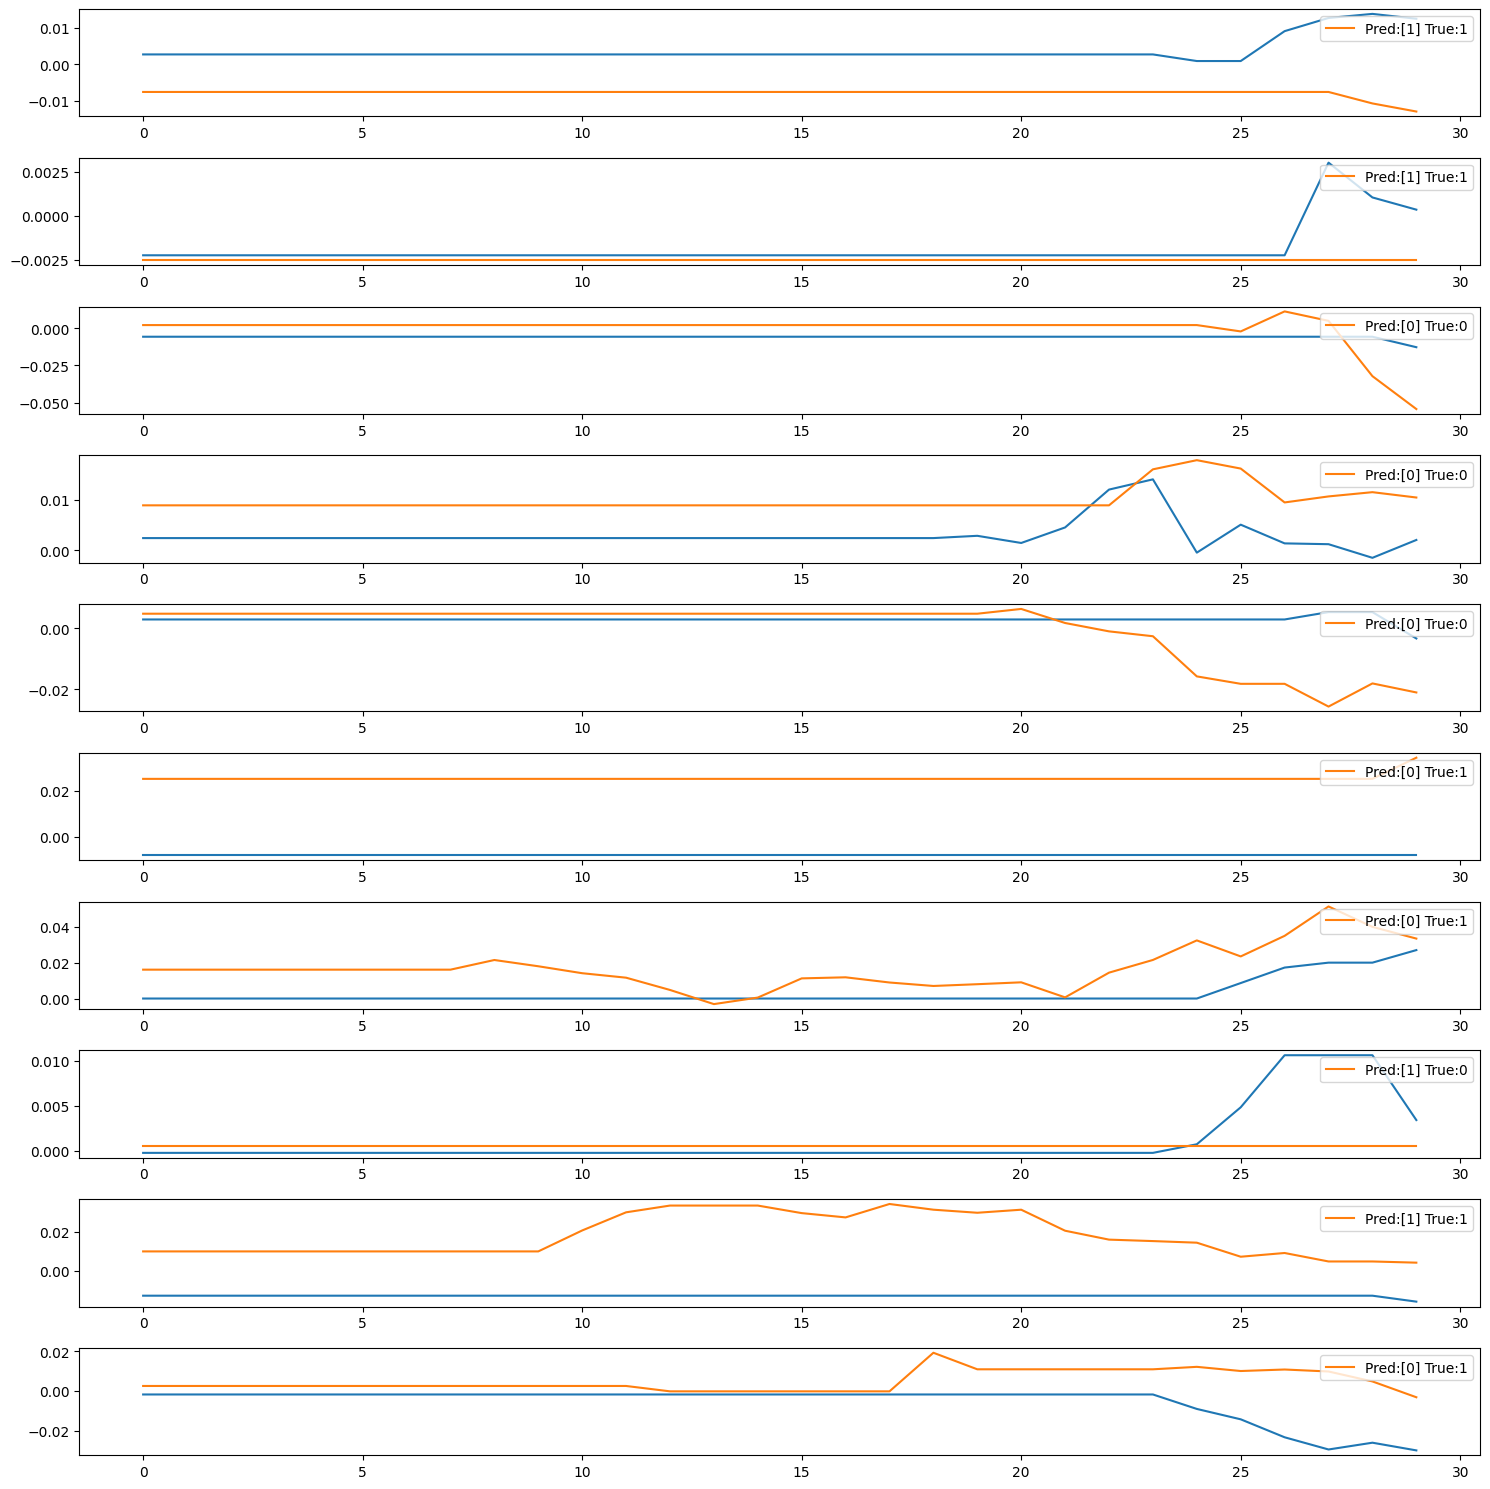

In [11]:
binary_array = (binary_model.predict(x_dict) >= 0.5).astype(int)
binary_array.flatten()

fig, axs = plt.subplots(10,1,figsize=(15,15))
for i in range(10):
    axs[i].plot(np.mean(x_dict["input1"][i],axis=-1))
    axs[i].plot(np.mean(x_dict["input2"][i],axis=-1),label="Pred:{} True:{}".format(binary_array[i],y[i]))
    axs[i].legend(loc="upper right")
    
fig.tight_layout()